In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# backtesting.set_bokeh_output(notebook=False)
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from backtesting import Backtest, Strategy
from IPython.display import display
from ipywidgets import IntProgress
from scipy.stats import shapiro

from src.het import het_breuschpagan
from src.ramsy import ramsey_reset_test


/home/strike/work/penv/deep/lib/python3.13/site-packages/backtesting/_plotting.py:54: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
p = "/home/strike/work/external/trade/mm_profect/general_reseach/regress/data_csv/"
d = os.listdir(p)
d.sort()
df = pd.read_csv(p + d[0])
df = df.dropna()  # .reset_index(drop=True)
# from datetime import datetime
df["ts_event"] = pd.to_datetime(df["ts_event"])
df["ts_event"] = df["ts_event"].dt.tz_localize(None)
df.set_index("ts_event", inplace=True)
# df = df[:10000]
data = df.loc[:, ["open", "high", "low", "close"]].rename(
    columns={"open": "Open", "high": "High", "low": "Low", "close": "Close"}
)
for i in range(1, len(d)):  # len(d)
    df = pd.read_csv(p + d[i])

    df = df.dropna()  # .reset_index(drop=True)
    # from datetime import datetime
    df["ts_event"] = pd.to_datetime(df["ts_event"])
    df["ts_event"] = df["ts_event"].dt.tz_localize(None)
    df.set_index("ts_event", inplace=True)
    # df = df[:10000]
    data1 = df.loc[:, ["open", "high", "low", "close"]].rename(
        columns={"open": "Open", "high": "High", "low": "Low", "close": "Close"}
    )
    data = pd.concat([data, data1])

3 weeks to week or week to week

In [4]:
# Установим начальную дату на первый понедельник
start_date = data.index.min() + pd.tseries.offsets.Week(weekday=0)
total_weeks = (data.index.max() - start_date).days // 7
total_weeks

42

In [7]:
class RegressionStrategy(Strategy):
    window = 202  # Количество свечей
    k = 35
    p_value_thresh = 0.1  # Порог стационарности

    def init(self):
        pass

    def next(self):
        # Пропускаем первые window свечей
        if len(self.data.Close) < self.window:
            return

        x = np.linspace(0, 1, num=self.window)
        one = np.ones_like(x)
        X = np.vstack([one, x, x**2]).T
        self.t_lin = np.linalg.inv(X.T @ X) @ X.T
        self.x = x

        # Берем последние window цен закрытия
        closes = self.data.Close[-self.window :]
        # Создаем массив индексов для регрессии
        # x = np.arange(len(closes))
        """
        result = adfuller(closes)
        p_value = result[1]
        
        # Если ряд не стационарен - не торгуем
    
        if p_value >= self.p_value_thresh:
            return
            """

        if not self.position:
            # Тест Рамсея на линейность
            _, s = ramsey_reset_test(self.x, closes - np.mean(closes))
            X = self.x.reshape(-1, 1)
            _, p_value = het_breuschpagan(X, closes)
            if (p_value < 0.1) * (s < 0.1):  # * (s < 0.1)
                return

        # тест на гетероскедантичность
        """
        X = self.x.reshape(-1,1)
        _, p_value = het_breuschpagan(X, closes)
        if (p_value>0.1) * (not self.position):
            return
        """

        # Рассчитываем коэффициенты линейной регрессии
        w = self.t_lin @ closes

        slope = w[1]
        intercept = w[0]
        # slope, intercept = np.polyfit(x, closes, 1)

        # Получаем линию регрессии
        regression_line = slope * self.x + intercept  # + w[2]*self.x**2

        # Рассчитываем СКО ошибок
        residuals = closes - regression_line

        # Тест на нормальность

        if not self.position:
            _, p_value = shapiro(residuals)
            if p_value < 0.1:
                return

        # Дарли Уотсона тест на постояноство ошибки (гетероскедантичность)
        """
        if (not self.position) * (durbin_watson(residuals)<0.7):
            return
            """
        std = np.std(residuals / (self.window - 2))

        # Текущие значения
        current_reg = regression_line[-1]
        current_price = closes[-1]
        upper_band = current_reg + std * self.k
        lower_band = current_reg - std * self.k

        # Логика торговли
        if not self.position:
            # Сигнал на продажу
            if current_price > upper_band:
                self.sell()

            # Сигнал на покупку
            elif current_price < lower_band:
                self.buy()

        else:
            # Выход из длинной позиции
            if self.position.is_long and current_price > current_reg:
                self.position.close()

            # Выход из короткой позиции
            elif self.position.is_short and current_price < current_reg:
                self.position.close()


In [5]:
ans = {}

In [8]:
# Цикл для выделения тренировочных и тестовых наборов
for i in range(total_weeks - 1):
    # Определяем начальную и конечную даты для тренировочного и тестового наборов
    train_start = start_date + pd.DateOffset(weeks=i)
    train_end = train_start + pd.DateOffset(weeks=1) - pd.Timedelta(days=1)
    test_start = train_end + pd.Timedelta(days=1)
    test_end = test_start + pd.DateOffset(weeks=1) - pd.Timedelta(days=1)

    # Выделяем тренировочный и тестовый наборы
    train_data = data[train_start:train_end]
    test_data = data[test_start:test_end]

    if (len(test_data) > 1000) * (len(train_data) > 1000):
        bt = Backtest(train_data, RegressionStrategy, cash=100000, commission=0.0000)
        stats = bt.optimize(
            k=range(20, 100),  # Перебираем целые значения от 1 до 100
            window=range(30, 300),
            maximize="Equity Final [$]",  # maximize=" Sharpe Ratio,  # Критерий оптимизации - конечный баланс
            method="grid",  # Метод перебора
            max_tries=100,  # Лимит количества комбинаций (можно увеличить)
        )

        # if len(test_data) > 1000:
        # stats._strategy.k, stats._strategy.window

        bt = Backtest(test_data, RegressionStrategy, cash=100000, commission=0.0000)

        class RegressionStrategy(Strategy):
            window = stats._strategy.window  # Количество свечей
            k = stats._strategy.k
            p_value_thresh = 0.1  # Порог стационарности

            def init(self):
                pass

            def next(self):
                # Пропускаем первые window свечей
                if len(self.data.Close) < self.window:
                    return

                x = np.linspace(0, 1, num=self.window)
                one = np.ones_like(x)
                X = np.vstack([one, x, x**2]).T
                self.t_lin = np.linalg.inv(X.T @ X) @ X.T
                self.x = x

                # Берем последние window цен закрытия
                closes = self.data.Close[-self.window :]
                # Создаем массив индексов для регрессии
                # x = np.arange(len(closes))
                """
                result = adfuller(closes)
                p_value = result[1]
                
                # Если ряд не стационарен - не торгуем
            
                if p_value >= self.p_value_thresh:
                    return
                    """

                if not self.position:
                    # Тест Рамсея на линейность
                    _, s = ramsey_reset_test(self.x, closes - np.mean(closes))
                    X = self.x.reshape(-1, 1)
                    _, p_value = het_breuschpagan(X, closes)
                    if (p_value < 0.1) * (s < 0.1):  # * (s < 0.1)
                        return

                # тест на гетероскедантичность
                """
                X = self.x.reshape(-1,1)
                _, p_value = het_breuschpagan(X, closes)
                if (p_value>0.1) * (not self.position):
                    return
                """

                # Рассчитываем коэффициенты линейной регрессии
                w = self.t_lin @ closes

                slope = w[1]
                intercept = w[0]
                # slope, intercept = np.polyfit(x, closes, 1)

                # Получаем линию регрессии
                regression_line = slope * self.x + intercept  # + w[2]*self.x**2

                # Рассчитываем СКО ошибок
                residuals = closes - regression_line

                # Тест на нормальность

                if not self.position:
                    _, p_value = shapiro(residuals)
                    if p_value < 0.1:
                        return

                # Дарли Уотсона тест на постояноство ошибки (гетероскедантичность)
                """
                if (not self.position) * (durbin_watson(residuals)<0.7):
                    return
                    """
                std = np.std(residuals / (self.window - 2))

                # Текущие значения
                current_reg = regression_line[-1]
                current_price = closes[-1]
                upper_band = current_reg + std * self.k
                lower_band = current_reg - std * self.k

                # Логика торговли
                if not self.position:
                    # Сигнал на продажу
                    if current_price > upper_band:
                        self.sell()

                    # Сигнал на покупку
                    elif current_price < lower_band:
                        self.buy()

                else:
                    # Выход из длинной позиции
                    if self.position.is_long and current_price > current_reg:
                        self.position.close()

                    # Выход из короткой позиции
                    elif self.position.is_short and current_price < current_reg:
                        self.position.close()

        stats = bt.run()
        ret = (
            stats._equity_curve.Equity.values[1:]
            - stats._equity_curve.Equity.values[:-1]
        ) / stats._equity_curve.Equity.values[:-1]
        ans[i] = ret

with open("data_1w.pkl", "wb") as file:
    pickle.dump(ans, file)


In [4]:
with open(r"data.pkl", "rb") as input_file:
    ans = pickle.load(input_file)

In [9]:
t = []
L = list(ans)
for j in L:
    t.append(np.cumsum(ans[j])[-1])

In [10]:
t1 = np.array(ans[0])

for j in L:
    if j != 0:
        t1 = np.concatenate([t1, np.array(ans[j])])

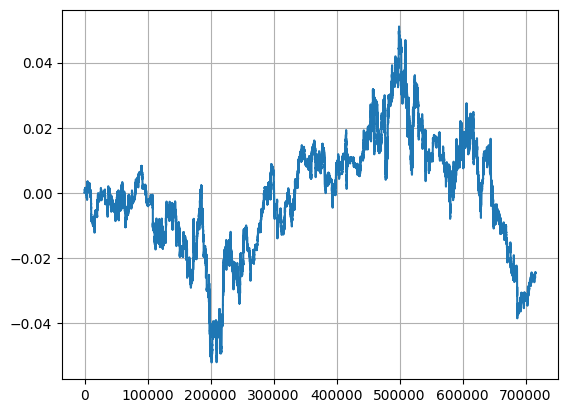

In [11]:
plt.plot(np.cumsum(t1))
plt.grid(True)

day to day

In [4]:
# Определяем рабочие дни в данных
business_days = pd.bdate_range(start=data.index.min(), end=data.index.max())

# Цикл для выделения тренировочных и тестовых наборов
for i in range(len(business_days) - 1):
    # Определяем начальную и конечную даты для тренировочного и тестового наборов
    train_start = business_days[i]
    train_end = train_start
    test_start = business_days[i + 1]
    test_end = test_start

    # Выделяем тренировочный и тестовый наборы
    train_data = data[train_start:train_end]
    test_data = data[test_start:test_end]

    # Выводим информацию о текущем наборе данных
    # print(f"Тренировочный набор: {train_start.date()}, размер: {len(train_data)}")
    # print(f"Тестовый набор: {test_start.date()}, размер: {len(test_data)}")

    # Здесь можно добавить код для обучения и тестирования модели


In [5]:
ans = {}

In [8]:
# Определяем рабочие дни в данных
business_days = pd.bdate_range(start=data.index.min(), end=data.index.max())
progress = IntProgress(min=0, max=40)  # IntProgress(min=0, max=len(business_days) - 2)
display(progress)


for i in range(120,160):  # len(business_days) - 1
    # Определяем начальную и конечную даты для тренировочного и тестового наборов
    train_start = business_days[i]
    train_end = train_start + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    test_start = business_days[i + 1]
    test_end = test_start + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

    # Выделяем тренировочный и тестовый наборы
    train_data = data[train_start:train_end]
    test_data = data[test_start:test_end]

    if (len(test_data) > 1000) * (len(train_data) > 1000):
        bt = Backtest(train_data, RegressionStrategy, cash=100000, commission=0.0000)
        stats = bt.optimize(
            k=range(15, 100),  # Перебираем целые значения от 1 до 100
            window=range(20, 300),
            maximize="Equity Final [$]",  # maximize=" Sharpe Ratio,  # Критерий оптимизации - конечный баланс
            method="sambo",  # Метод перебора
            max_tries=100,  # Лимит количества комбинаций (можно увеличить)
        )

        # if len(test_data) > 1000:
        # stats._strategy.k, stats._strategy.window

        bt = Backtest(test_data, RegressionStrategy, cash=100000, commission=0.0000)

        class RegressionStrategy(Strategy):
            window = stats._strategy.window  # Количество свечей
            k = stats._strategy.k
            p_value_thresh = 0.1  # Порог стационарности

            def init(self):
                pass

            def next(self):
                # Пропускаем первые window свечей
                if len(self.data.Close) < self.window:
                    return

                x = np.linspace(0, 1, num=self.window)
                one = np.ones_like(x)
                X = np.vstack([one, x, x**2]).T
                self.t_lin = np.linalg.inv(X.T @ X) @ X.T
                self.x = x

                # Берем последние window цен закрытия
                closes = self.data.Close[-self.window :]
                # Создаем массив индексов для регрессии
                # x = np.arange(len(closes))
                """
                result = adfuller(closes)
                p_value = result[1]
                
                # Если ряд не стационарен - не торгуем
            
                if p_value >= self.p_value_thresh:
                    return
                    """

                if not self.position:
                    # Тест Рамсея на линейность
                    _, s = ramsey_reset_test(self.x, closes - np.mean(closes))
                    X = self.x.reshape(-1, 1)
                    _, p_value = het_breuschpagan(X, closes)
                    if (p_value < 0.1) * (s < 0.1):  # * (s < 0.1)
                        return

                # тест на гетероскедантичность
                """
                X = self.x.reshape(-1,1)
                _, p_value = het_breuschpagan(X, closes)
                if (p_value>0.1) * (not self.position):
                    return
                """

                # Рассчитываем коэффициенты линейной регрессии
                w = self.t_lin @ closes

                slope = w[1]
                intercept = w[0]
                # slope, intercept = np.polyfit(x, closes, 1)

                # Получаем линию регрессии
                regression_line = slope * self.x + intercept  # + w[2]*self.x**2

                # Рассчитываем СКО ошибок
                residuals = closes - regression_line

                # Тест на нормальность

                if not self.position:
                    _, p_value = shapiro(residuals)
                    if p_value < 0.1:
                        return

                # Дарли Уотсона тест на постояноство ошибки (гетероскедантичность)
                """
                if (not self.position) * (durbin_watson(residuals)<0.7):
                    return
                    """
                std = np.std(residuals / (self.window - 2))

                # Текущие значения
                current_reg = regression_line[-1]
                current_price = closes[-1]
                upper_band = current_reg + std * self.k
                lower_band = current_reg - std * self.k

                # Логика торговли
                if not self.position:
                    # Сигнал на продажу
                    if current_price > upper_band:
                        self.sell()

                    # Сигнал на покупку
                    elif current_price < lower_band:
                        self.buy()

                else:
                    # Выход из длинной позиции
                    if self.position.is_long and current_price > current_reg:
                        self.position.close()

                    # Выход из короткой позиции
                    elif self.position.is_short and current_price < current_reg:
                        self.position.close()

        stats = bt.run()
        ret = (
            stats._equity_curve.Equity.values[1:]
            - stats._equity_curve.Equity.values[:-1]
        ) / stats._equity_curve.Equity.values[:-1]
        ans[i] = ret

with open("data_1day_3.pkl", "wb") as file:
    pickle.dump(ans, file)


IntProgress(value=0, max=40)

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
t = []
L = list(ans)
for j in L:
    t.append(np.cumsum(ans[j])[-1])

t1 = np.array(ans[120])

for j in L:
    if j != 0 :
        t1 = np.concatenate([t1, np.array(ans[j])])

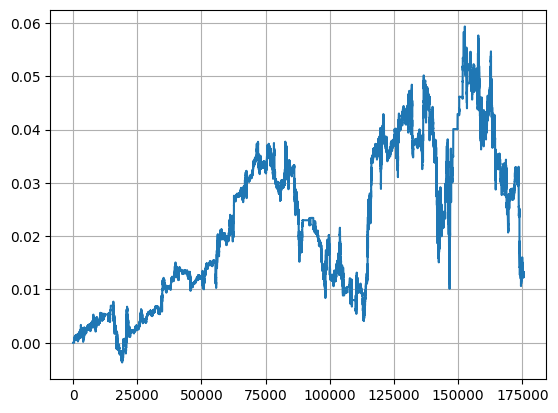

In [11]:
plt.plot(np.cumsum(t1))
plt.grid(True)

In [9]:
ans

{120: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.49497886e-05, -9.97966643e-05, -1.24758281e-05], shape=(4857,)),
 121: array([0., 0., 0., ..., 0., 0., 0.], shape=(2698,)),
 122: array([0., 0., 0., ..., 0., 0., 0.], shape=(4060,)),
 123: array([ 0.        ,  0.        ,  0.        , ...,  0.00035137,
        -0.00061469, -0.00012552], shape=(1017,)),
 130: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.96303713e-06, -1.99258757e-05,  0.00000000e+00], shape=(5447,)),
 131: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.99496845e-05, 2.99487876e-05, 9.98263022e-06], shape=(4434,)),
 132: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.99598806e-05,  0.00000000e+00,  0.00000000e+00], shape=(4100,)),
 133: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.99207156e-05, 5.97609562e-05], shape=(4940,)),
 134: array([0., 0., 0., ..., 0., 0., 0.], shape